In [57]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set_style("ticks")
sbn.set_palette('colorblind')

plt.rcParams['axes.labelpad'] = 10
plt.rcParams['axes.labelsize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 'xx-large'
plt.rcParams['ytick.labelsize'] = 'xx-large'

plt.rcParams['legend.title_fontsize'] = 'xx-large'
plt.rcParams['legend.fontsize'] = 'x-large'

%matplotlib inline

In [16]:
with open('/Volumes/thesis-data/dtype_dict.json') as dtypes:
    dtypes = json.load(dtypes)

df = pd.read_csv('/Volumes/thesis-data/cwmtaf.csv', dtype=dtypes,
                 parse_dates=['PERIOD', 'ADMDATE', 'DISCDATE'])

In [17]:
practices = pd.read_csv('../rsc/practice_codes.csv')

Extract our practice codes

In [18]:
observed_practice_codes = df['practice_code'].dropna().values
known_practice_codes = [c for c in observed_practice_codes if c in practices['PracticeCode'].values]

our_practices = practices[practices['PracticeCode'].isin(known_practice_codes)]
our_practices['District'] = our_practices['Postcode'].map(lambda x: str(x).split()[0])

/Users/henrywilde/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Postcode datasets, and extracting just the Welsh one

In [19]:
areas = gpd.read_file('../rsc/shapes/postcode_areas/Areas.shp')
districts = gpd.read_file('../rsc/shapes/postcode_districts/Districts.shp')
sectors = gpd.read_file('../rsc/shapes/postcode_sectors/Sectors.shp')

In [20]:
our_practices['Sector'] = our_practices['Postcode'].map(lambda x: str(x).split()[0] + ' ' + str(x).split()[1][0])

/Users/henrywilde/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
our_district_codes = our_practices['District'].unique()
districts['postcode_area'] = districts['name'].apply(lambda x: str(x)[:2])

welsh_areas = areas[areas['name'].isin(['CF', 'CH', 'HR', 'NP', 'GL', 'LD', 'LL', 'SA', 'SY'])]
welsh_districts = districts[districts['postcode_area'].isin(['CF', 'CH', 'HR', 'NP', 'GL', 'LD', 'LL', 'SA', 'SY'])]
our_districts = districts[districts['name'].isin(our_district_codes)]

welsh_areas['centroid'] = welsh_areas['geometry'].centroid
welsh_districts['centroid'] = welsh_districts['geometry'].centroid

/Users/henrywilde/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/henrywilde/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


The 2011 LSOA codes, restricted to those in Wales

In [22]:
lsoas = gpd.read_file('../rsc/shapes/LSOA_2011/Lower_Layer_Super_Output_Areas_December_2011_Full_Extent__Boundaries_in_England_and_Wales.shp')
lsoas = lsoas.to_crs(welsh_districts.crs).loc[lsoas['lsoa11cd'].str.get(0) == 'W']

lsoas['County'] = lsoas.apply(lambda x: ' '.join(x['lsoa11nm'].split(' ')[:-1]), axis=1)

Map out the counties of Wales

In [23]:
counties = lsoas.dissolve(by='County')

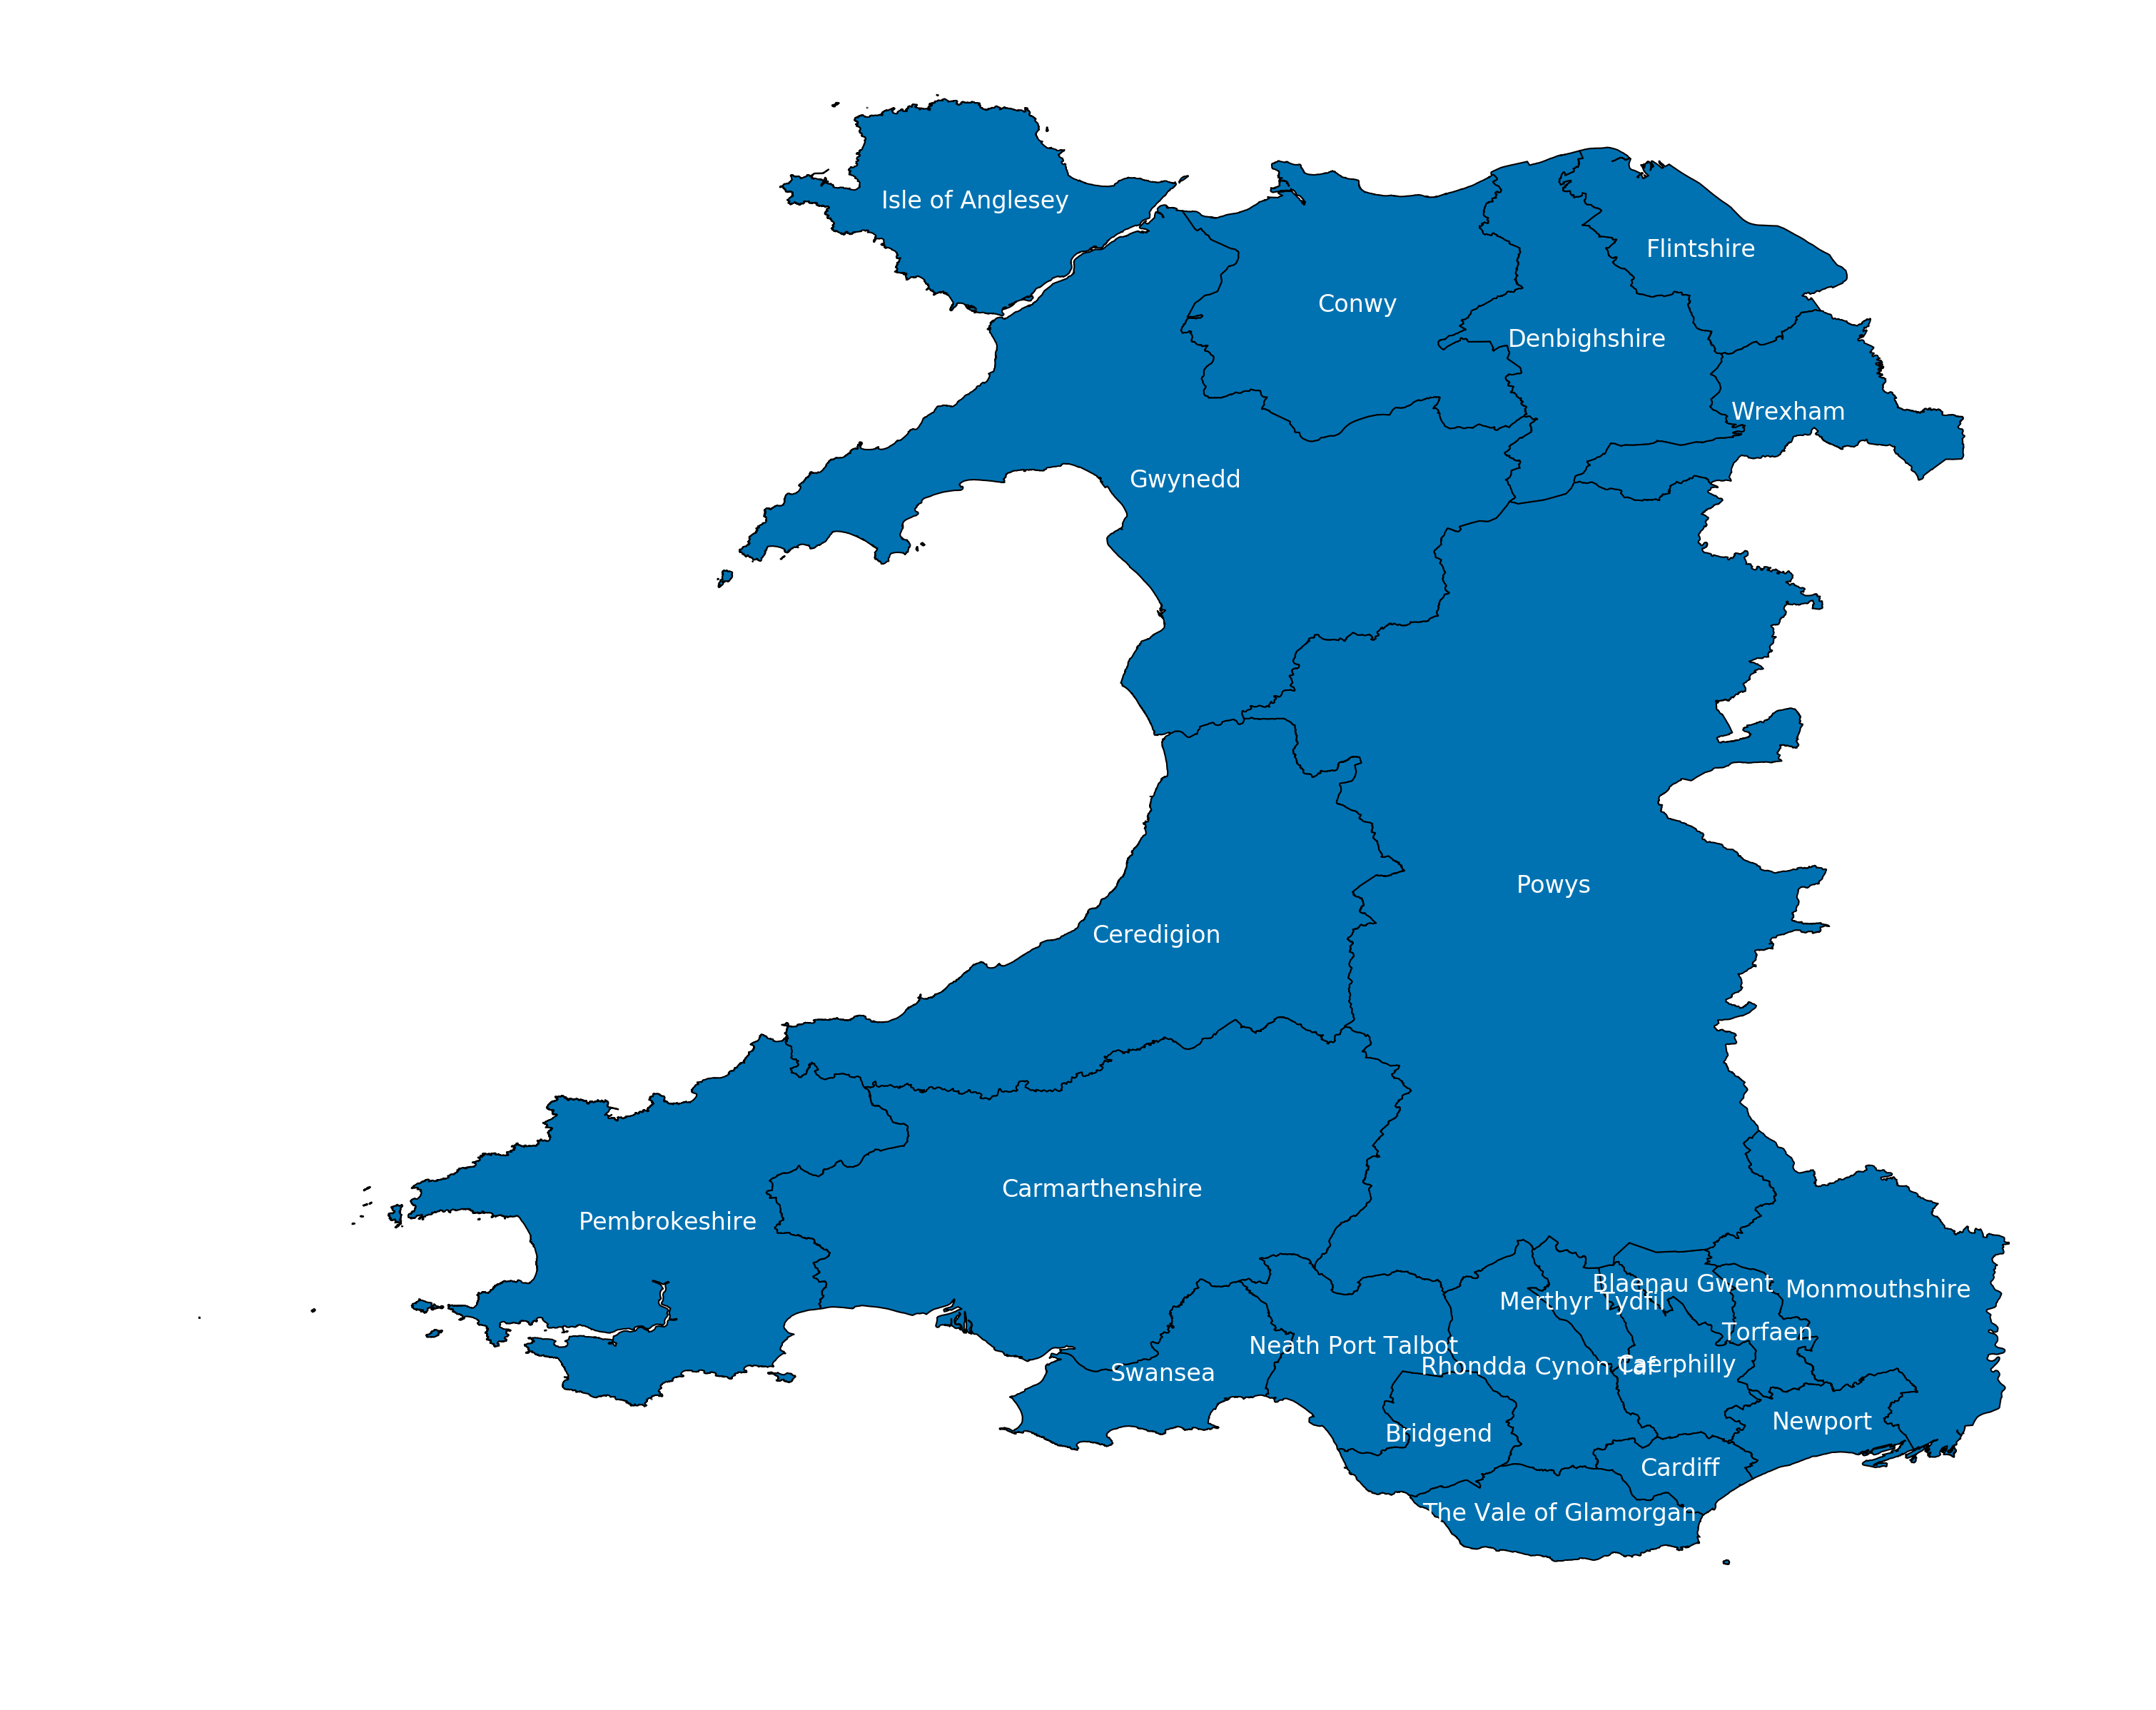

In [24]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=300)

counties.plot(ax=ax, edgecolor='k', lw=0.5)

for county in counties.iterrows():
    ax.text(county[1]['geometry'].centroid.x,
            county[1]['geometry'].centroid.y,
            county[0], color='white', fontsize=8,
            horizontalalignment='center',
            verticalalignment='center'
    )

ax.axis('off');

In [25]:
cwmtaf_lsoas = lsoas[lsoas['County'].isin(['Merthyr Tydfil', 'Rhondda Cynon Taf'])]
cwmtaf_counties = cwmtaf_lsoas.dissolve(by='County')

In [26]:
wimd_ranks = pd.read_csv('../rsc/WIMD.csv')

cwmtaf_lsoas.set_index('lsoa11cd', inplace=True)
for col in wimd_ranks.columns:
    if col not in ['LSOA11', 'LSOA11CD', 'county']:
        cwmtaf_lsoas[col] = wimd_ranks.set_index('LSOA11CD')[col]
cwmtaf_lsoas.reset_index(inplace=True)

/Users/henrywilde/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Postcode conversion, and Cwm Taf specifically

In [27]:
conversions = pd.read_csv('../rsc/PCDtoOA.csv', low_memory=False)
cwmtaf_conversions = conversions[conversions['LAD11NM'].isin(cwmtaf_lsoas['County'].unique())]

In [28]:
hospital_names = ['PCH', 'RGH', 'DSH']
hospital_PCDs = ['CF47 9DT', 'CF72 8XR', 'CF37 1EB']
hospital_codes = cwmtaf_conversions.set_index('PCD8').loc[hospital_PCDs]['LSOA11CD'].values

centroids = cwmtaf_lsoas.set_index('lsoa11cd').loc[hospital_codes]['geometry'].centroid
hospital_locs = gpd.GeoDataFrame({'name': hospital_names, 'centroid': centroids})

In [29]:
index_components = np.array([c for c in wimd_ranks.columns if c not in ['county', 'LSOA11', 'LSOA11CD']])

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20), dpi=400)

vmin = 1
vmax = 1909

for col, component_col in zip(axes.T, index_components.reshape(3, 3)):
    i = 0
    for ax in col:
        counties.plot(ax=ax, edgecolor='k', facecolor='None')
        component = component_col[i]
        cwmtaf_lsoas.plot(component, ax=ax, cmap='viridis_r', vmin=vmin, vmax=vmax, edgecolor='k', lw=0.5)
        cwmtaf_counties.plot(ax=ax, facecolor='None', edgecolor='k', lw=1)

        ax.axis('off')
        if component == 'WIMD':
            ax.set_title(component, fontsize=20)
        else:
            ax.set_title(component.replace('_', ' ').title(), fontsize=20)
        i += 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_ylabel('Deprivation rank', fontsize=20)

# plt.savefig('/Users/henrywilde/thesis/tex/overview/img/external/WIMD.pdf', transparent=True);

In [30]:
cwmtaf_lsoa_centroids = gpd.GeoDataFrame(cwmtaf_lsoas['geometry'].centroid, columns=['geometry'])
cwmtaf_lsoa_centroids.crs = lsoas.crs

In [31]:
sectors = sectors.to_crs(lsoas.crs)
cwmtaf_sectors = gpd.tools.sjoin(sectors, cwmtaf_lsoa_centroids, how='inner', op='intersects')
cwmtaf_districts = gpd.tools.sjoin(districts, cwmtaf_lsoa_centroids, how='inner', op='intersects')

In [32]:
cwmtaf_lsoas['centroid'] = cwmtaf_lsoas['geometry'].centroid

/Users/henrywilde/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
components = {idx: [[] for _ in range(len(cwmtaf_sectors))] for idx in index_components}
for sector_idx in range(len(cwmtaf_sectors)):
    sector = cwmtaf_sectors.iloc[sector_idx]
    for lsoa_idx in range(len(cwmtaf_lsoas)):
        lsoa = cwmtaf_lsoas.iloc[lsoa_idx]
        if lsoa['centroid'].within(sector['geometry']):
            for comp in index_components:
                components[comp][sector_idx] += [lsoa[comp]]

In [34]:
for key, val in components.items():
    cwmtaf_sectors[key] = val

In [35]:
components = {idx: [] for idx in index_components}
for sector_idx in range(len(cwmtaf_sectors)):
    sector = cwmtaf_sectors.iloc[sector_idx]
    for component in index_components:
        components[component] += [np.mean(sector[component])]

In [36]:
for key, val in components.items():
    cwmtaf_sectors[key] = val

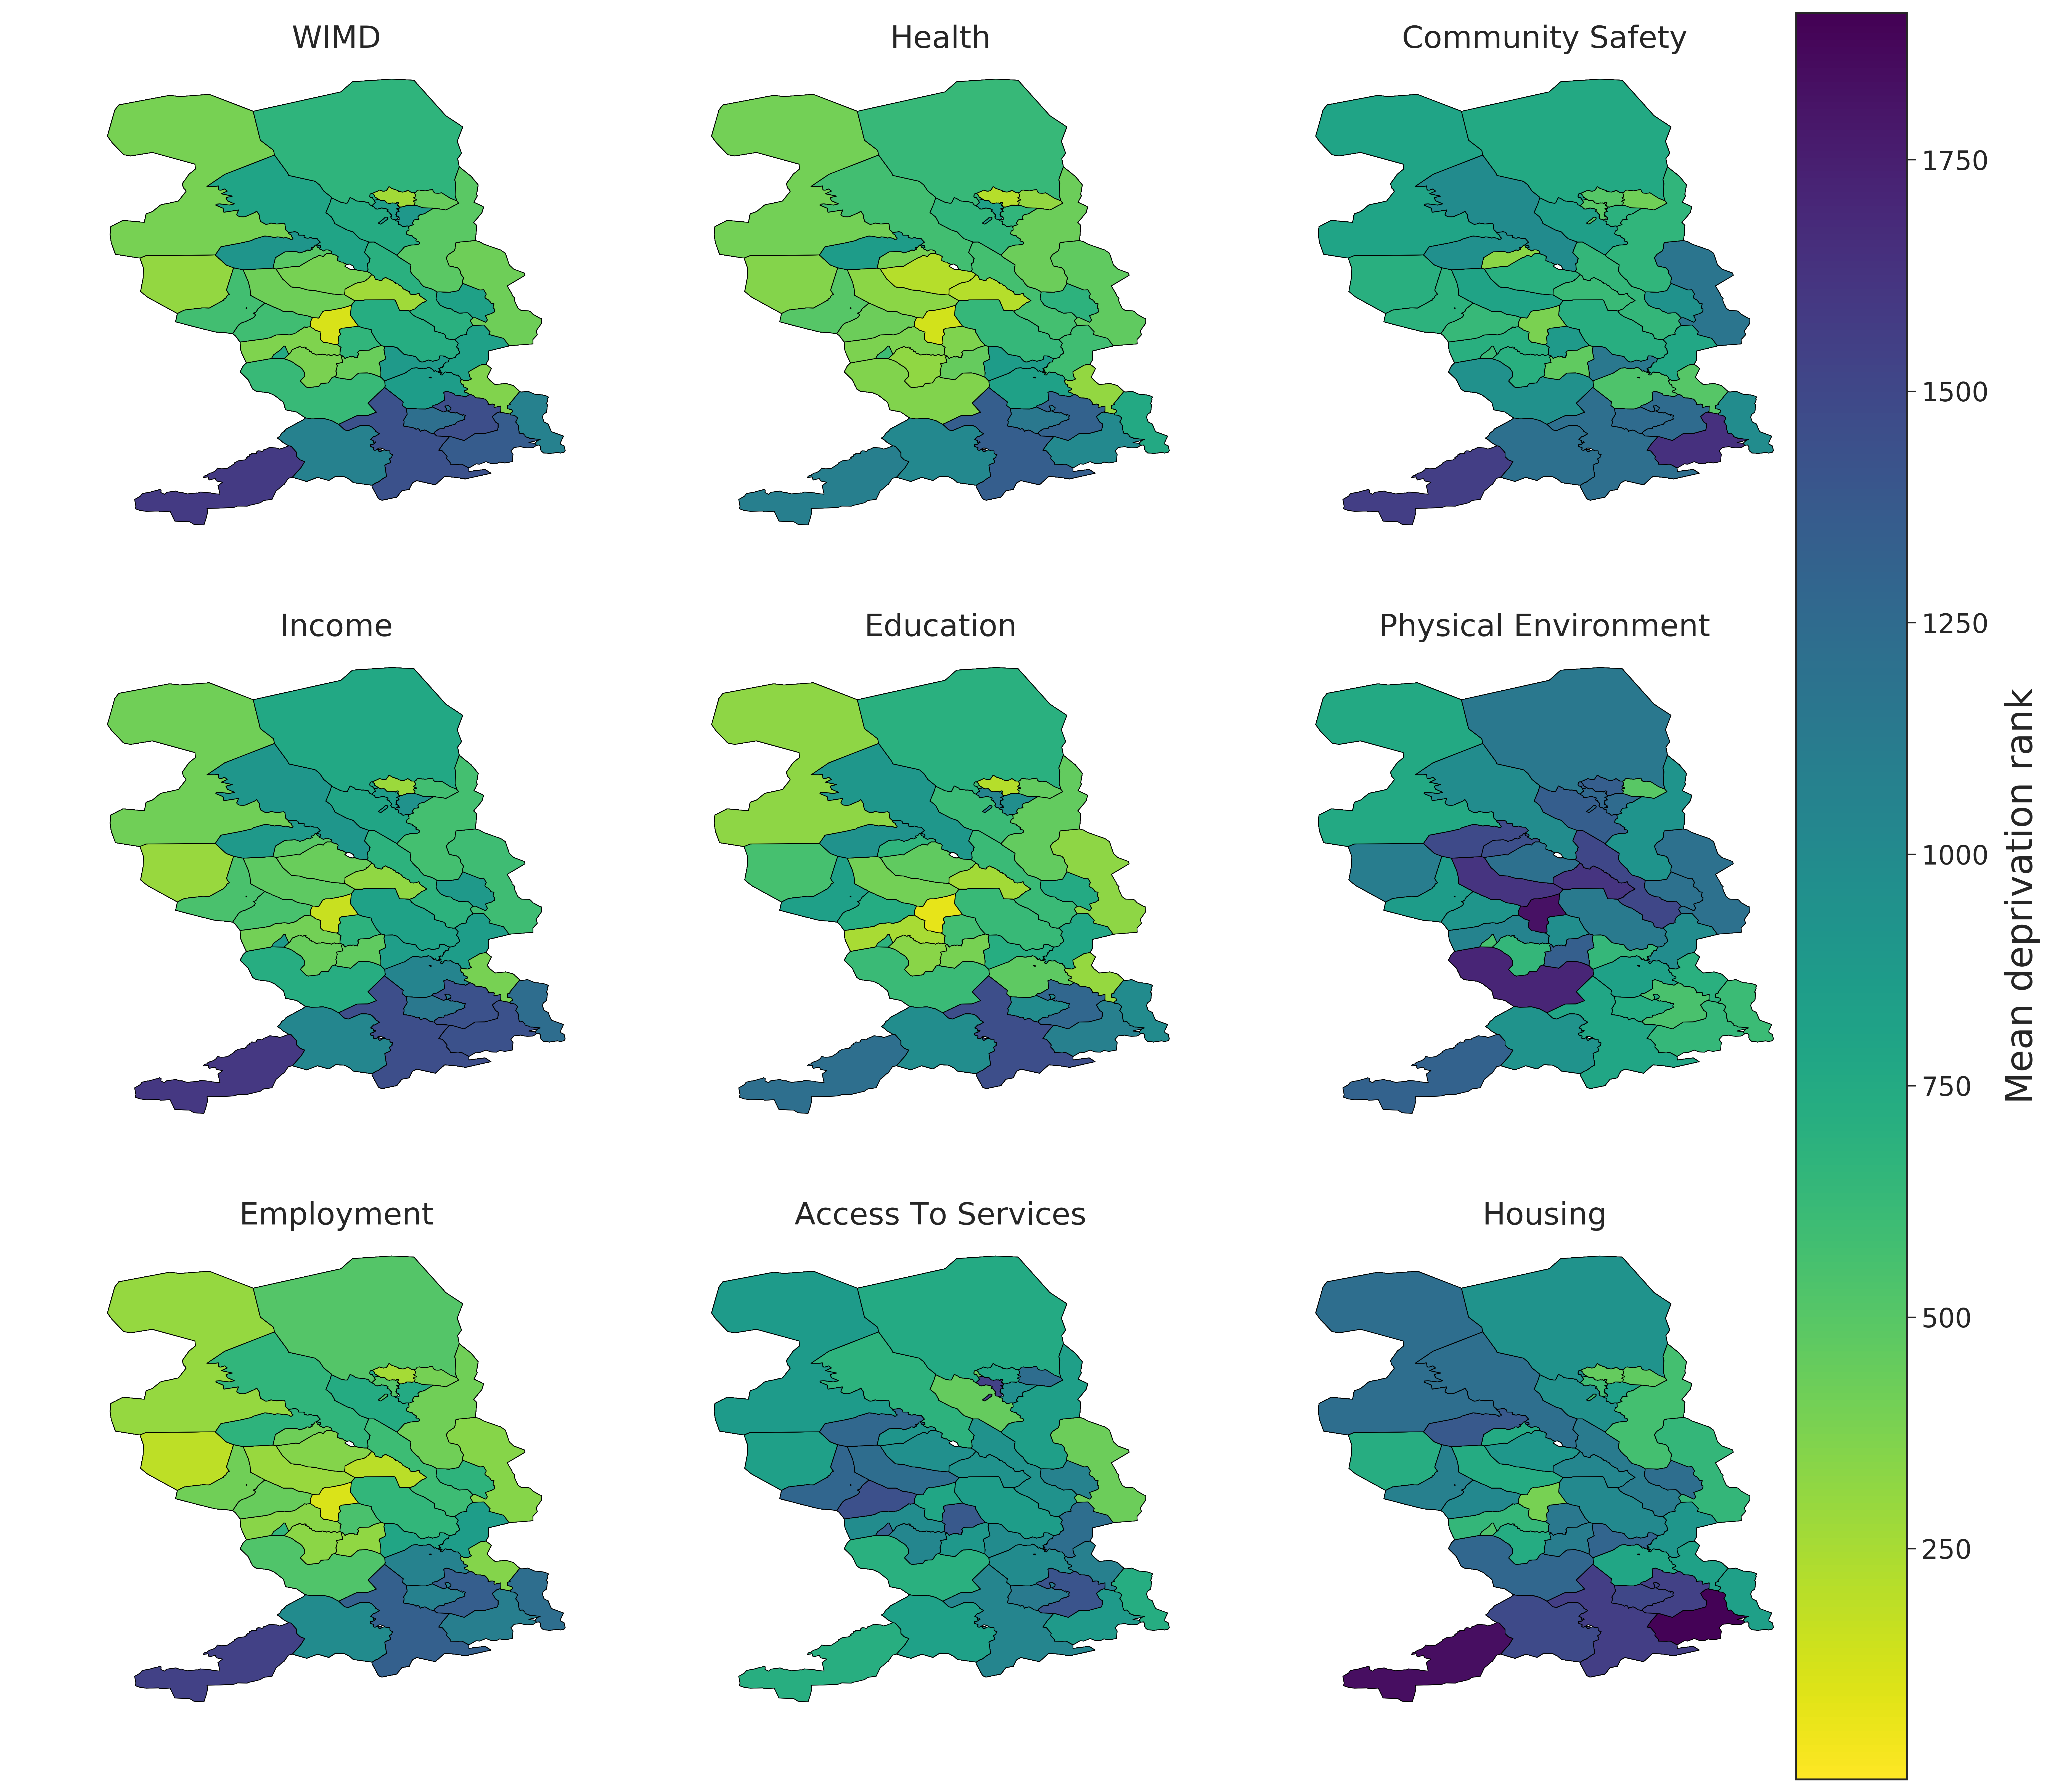

In [77]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20), dpi=400)

cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.8])

vmin = 1
vmax = 1909

for col, component_col in zip(axes.T, index_components.reshape(3, 3)):
    i = 0
    for ax in col:
        component = component_col[i]
        cwmtaf_sectors.plot(
            ax=ax, facecolor='None', hatch='....', edgecolor='k', lw=0.5
        )
        cwmtaf_sectors.dropna().plot(
            component, ax=ax, cmap='viridis_r', vmin=vmin, vmax=vmax, edgecolor='k', lw=0.5
        )

        ax.axis('off')
        if component == 'WIMD':
            ax.set_title(component, fontsize=20)
        else:
            ax.set_title(component.replace('_', ' ').title(), fontsize=20)
        i += 1

sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_ylabel('Mean deprivation rank', fontsize=24)

for label in cbar.ax.get_xticklabels():
    label.set_fontsize(24)

plt.savefig('/Users/henrywilde/thesis/tex/data-analysis/img/external/WIMD_Sectors.pdf', transparent=True);

# Geographic analysis

We hope to visualise aspects and trends in the data in relation to the geography of our patients. The GP practice of every patient is recorded in the data, and the health board has kindly provided the decodings of most of these practice codes.

Here we will extract the observed codes in the data, find their decoded information and then reduce the main dataset down to only include records for patients that we have information for. From there we can begin our analysis.

In [ ]:
fig, ax = plt.subplots(1, figsize=(8, 8), dpi=300)

welsh_districts.plot(ax=ax, facecolor='None', edgecolor='k', lw=0.25)
our_districts.plot(ax=ax, edgecolor='k', lw=0.25)

ax.axis('off');

In [37]:
patient_counts = df.groupby('practice_code')['PATIENT_ID'].nunique()\
                                                          .loc[known_practice_codes]

patient_counts = patient_counts[~patient_counts.index.duplicated(keep='first')]

our_practices = our_practices.set_index('PracticeCode')

mean_netcost = df.groupby(['practice_code', 'SPELL_ID'])['NetCost'].sum()\
                                                                   .reset_index()\
                                                                   .groupby('practice_code')['NetCost']\
                                                                   .mean()\
                                                                   .loc[known_practice_codes]

mean_netcost = mean_netcost[~mean_netcost.index.duplicated(keep='first')]

std_netcost = df.groupby(['practice_code', 'SPELL_ID'])['NetCost'].sum()\
                                                                  .reset_index()\
                                                                  .groupby('practice_code')['NetCost']\
                                                                  .std()\
                                                                  .loc[known_practice_codes]
                
std_netcost = std_netcost[~std_netcost.index.duplicated(keep='first')]
var_netcost = std_netcost / mean_netcost

avg_length = df.drop_duplicates('SPELL_ID').groupby('practice_code')['TRUE_LOS'].mean()\
                                                                                .loc[known_practice_codes]

avg_length = avg_length[~avg_length.index.duplicated(keep='first')]

our_practices['patient_count'] = patient_counts
our_practices['avg_netcost'] = mean_netcost
our_practices['avg_LOS'] = avg_length
our_practices['var_netcost'] = var_netcost
our_practices = our_practices.reset_index()

patient_sums = our_practices.groupby('District')['patient_count'].sum()
avg_netcosts = our_practices.groupby('District')['avg_netcost'].mean()
avg_lengths = our_practices.groupby('District')['avg_LOS'].mean()
var_netcosts = our_practices.groupby('District')['var_netcost'].mean()

our_districts = our_districts.set_index('name')
our_districts['patient_count'] = patient_sums
our_districts['avg_netcost'] = avg_netcosts
our_districts['avg_LOS'] = avg_lengths
our_districts['var_netcost'] = var_netcosts
our_districts = our_districts.reset_index()

# Proportion of all patients

In [44]:
our_districts['patient_proportion'] = our_districts['patient_count'] / our_districts['patient_count'].sum()

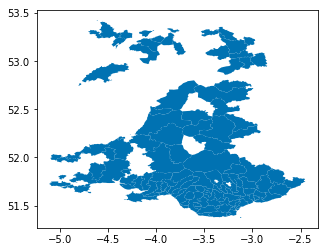

In [50]:
our_districts.plot()

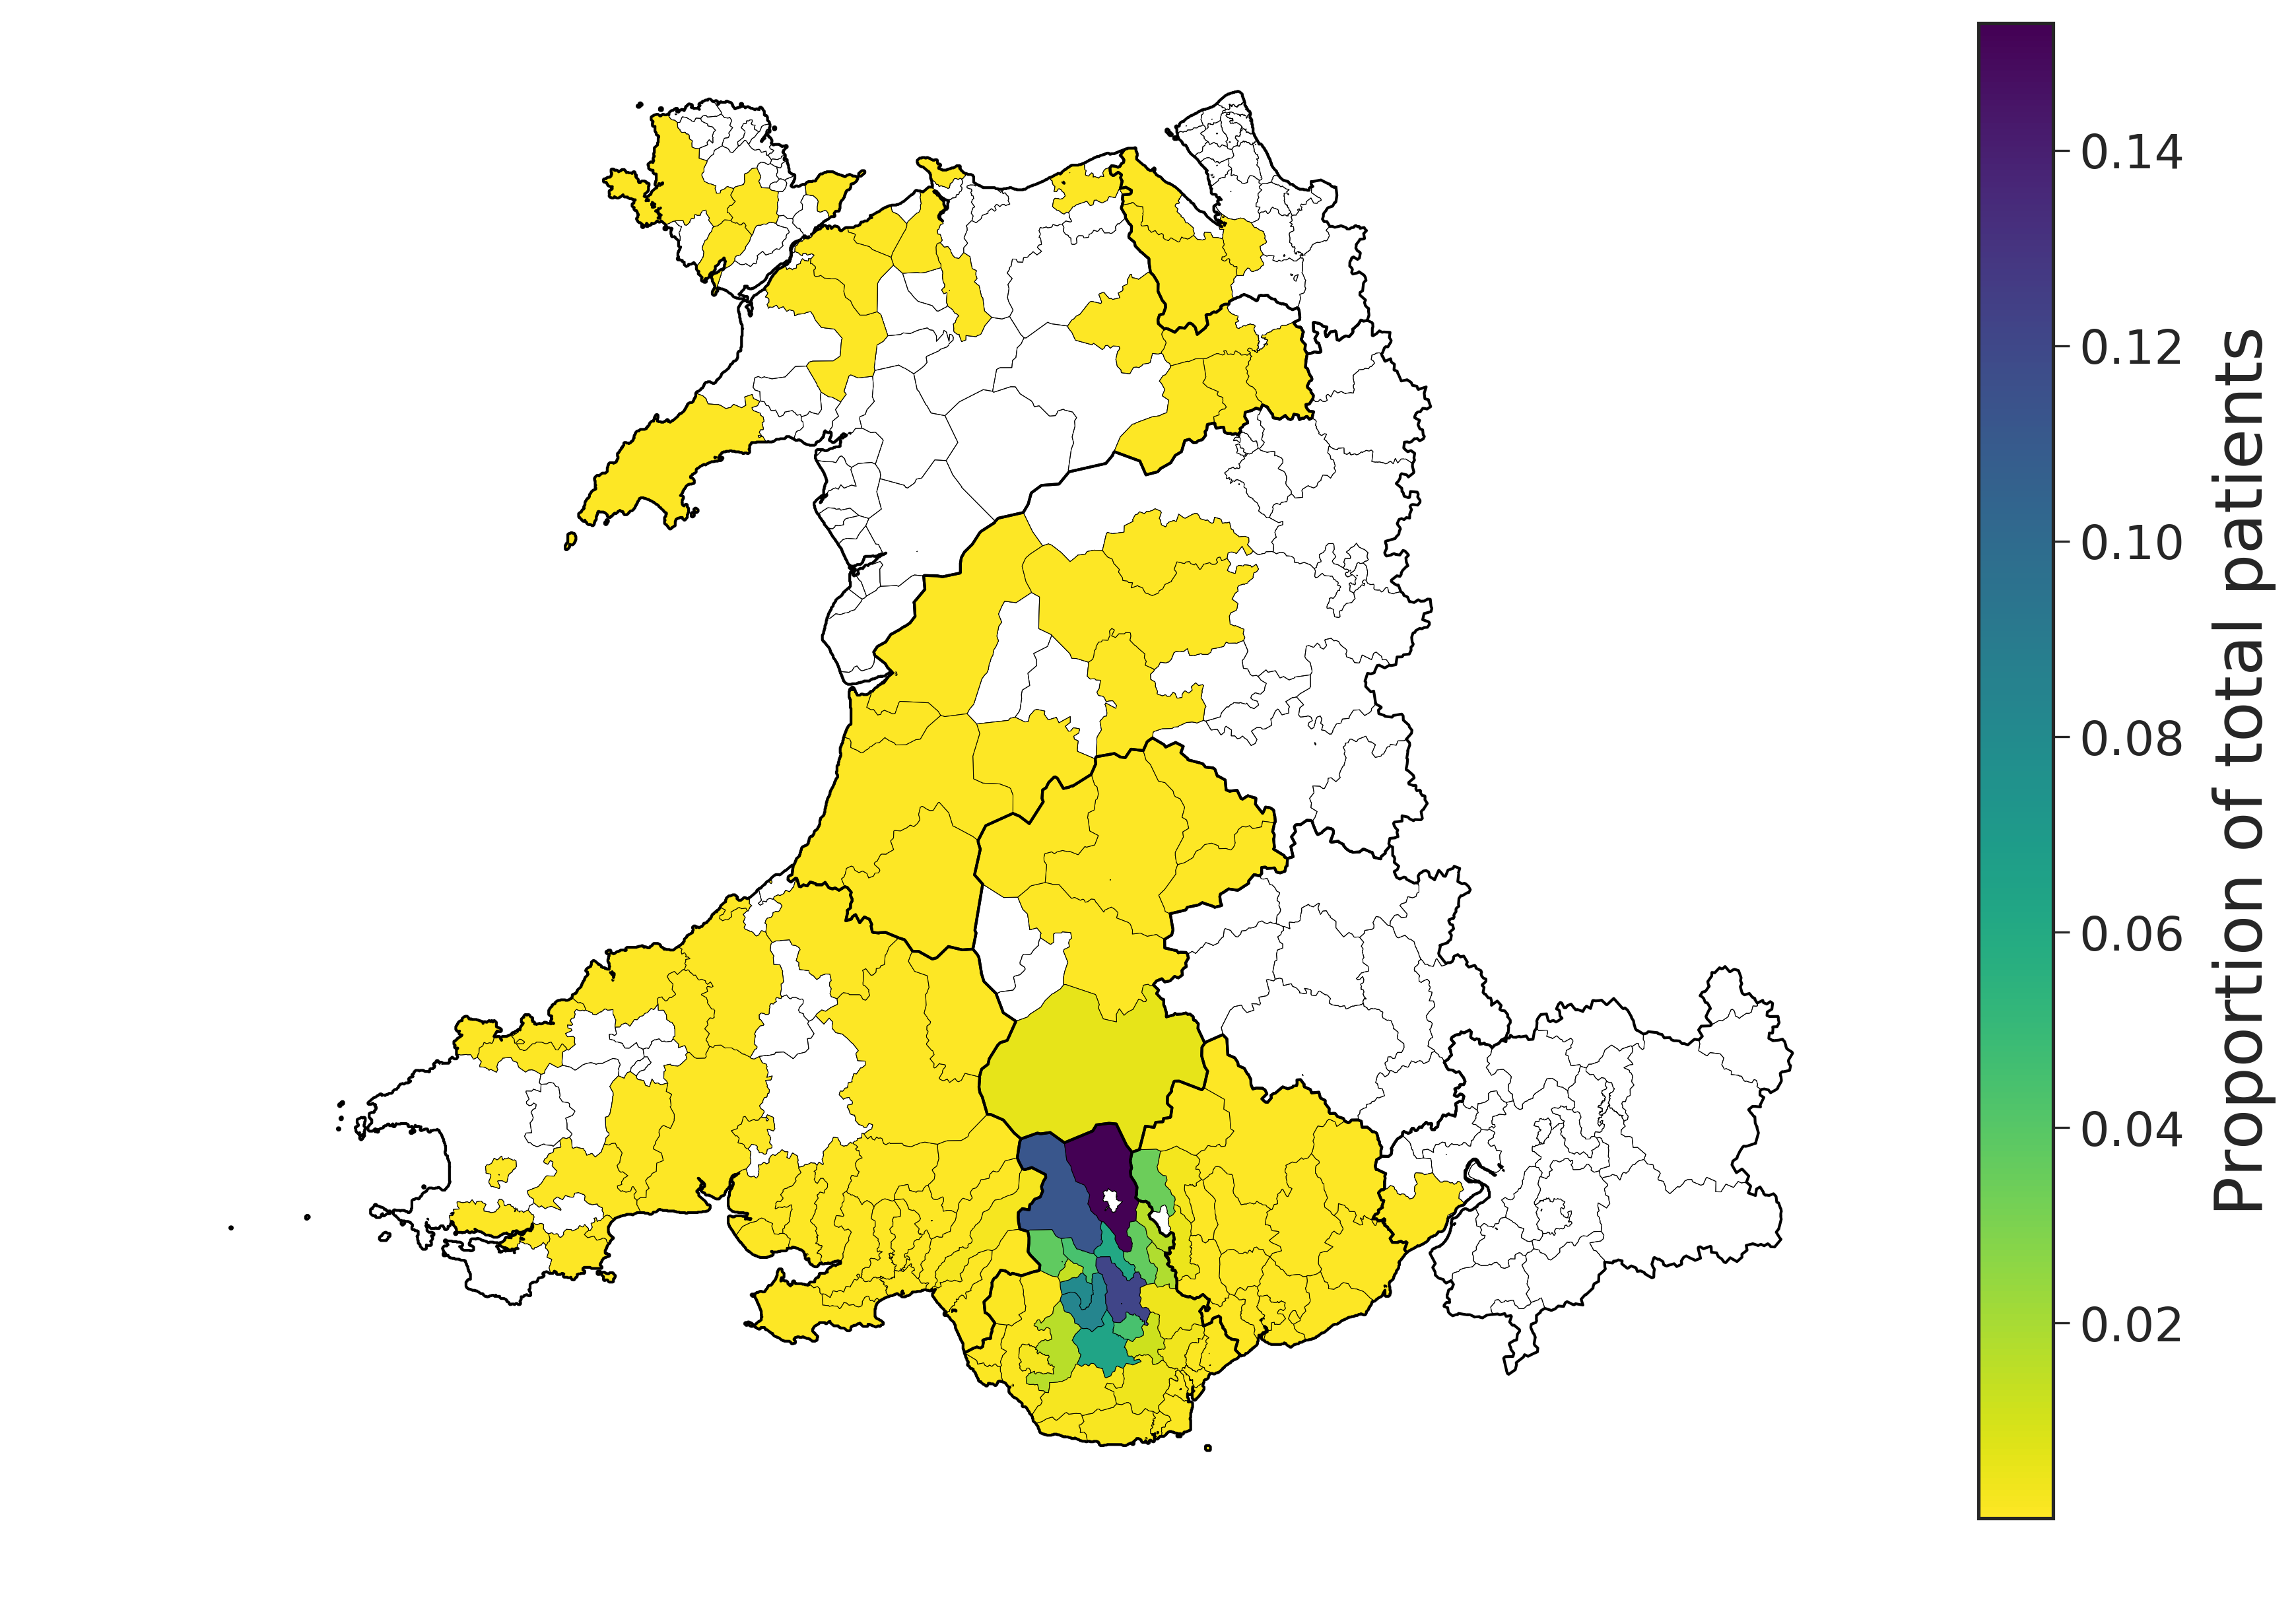

In [62]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

vmin = our_districts['patient_proportion'].min()
vmax = our_districts['patient_proportion'].max()

welsh_districts.plot(
    ax=ax, color='None', edgecolor='k', linewidth=0.25
)

our_districts.plot(
    'patient_proportion', cmap='viridis_r',
    vmin=vmin, vmax=vmax, ax=ax, edgecolor='k', linewidth=0.25
)
welsh_areas.plot(
    ax=ax, facecolor='None', edgecolor='k', linewidth=1
)

sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.set_ylabel('Proportion of total patients', fontsize=24)

for label in cbar.ax.get_xticklabels():
    label.set_fontsize(24)

# ax.set_xlim(-3.8, -3)
# ax.set_ylim(51.3, 52)
ax.axis('off');

plt.savefig('/Users/henrywilde/thesis/tex/data-analysis/img/external/proportion_wales.pdf', transparent=True);

In [ ]:
our_districts['log_patient'] = np.log(our_districts['patient_proportion'])

In [67]:
# fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

# vmin = our_districts['log_patient'].min()
# vmax = our_districts['log_patient'].max()

# welsh_districts.plot(
#     ax=ax, color='white', edgecolor='k', linewidth=0.25
# )
# our_districts.plot(
#     'log_patient', cmap='viridis_r', ax=ax,
#     vmin=vmin, vmax=vmax, edgecolor='k', linewidth=0.25
# )
# welsh_areas.plot(
#     ax=ax, facecolor='None', edgecolor='k', linewidth=1
# )

# sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm._A = []
# cbar = fig.colorbar(sm, label='Logarithm of proportion of total patients')

# for label in cbar.ax.get_xticklabels():
#     label.set_fontsize(24)

# ax.axis('off')

# plt.savefig('/Users/henrywilde/thesis/tex/overview/img/external/log_proportion_wales.pdf', transparent=True);

# Average net cost of spell

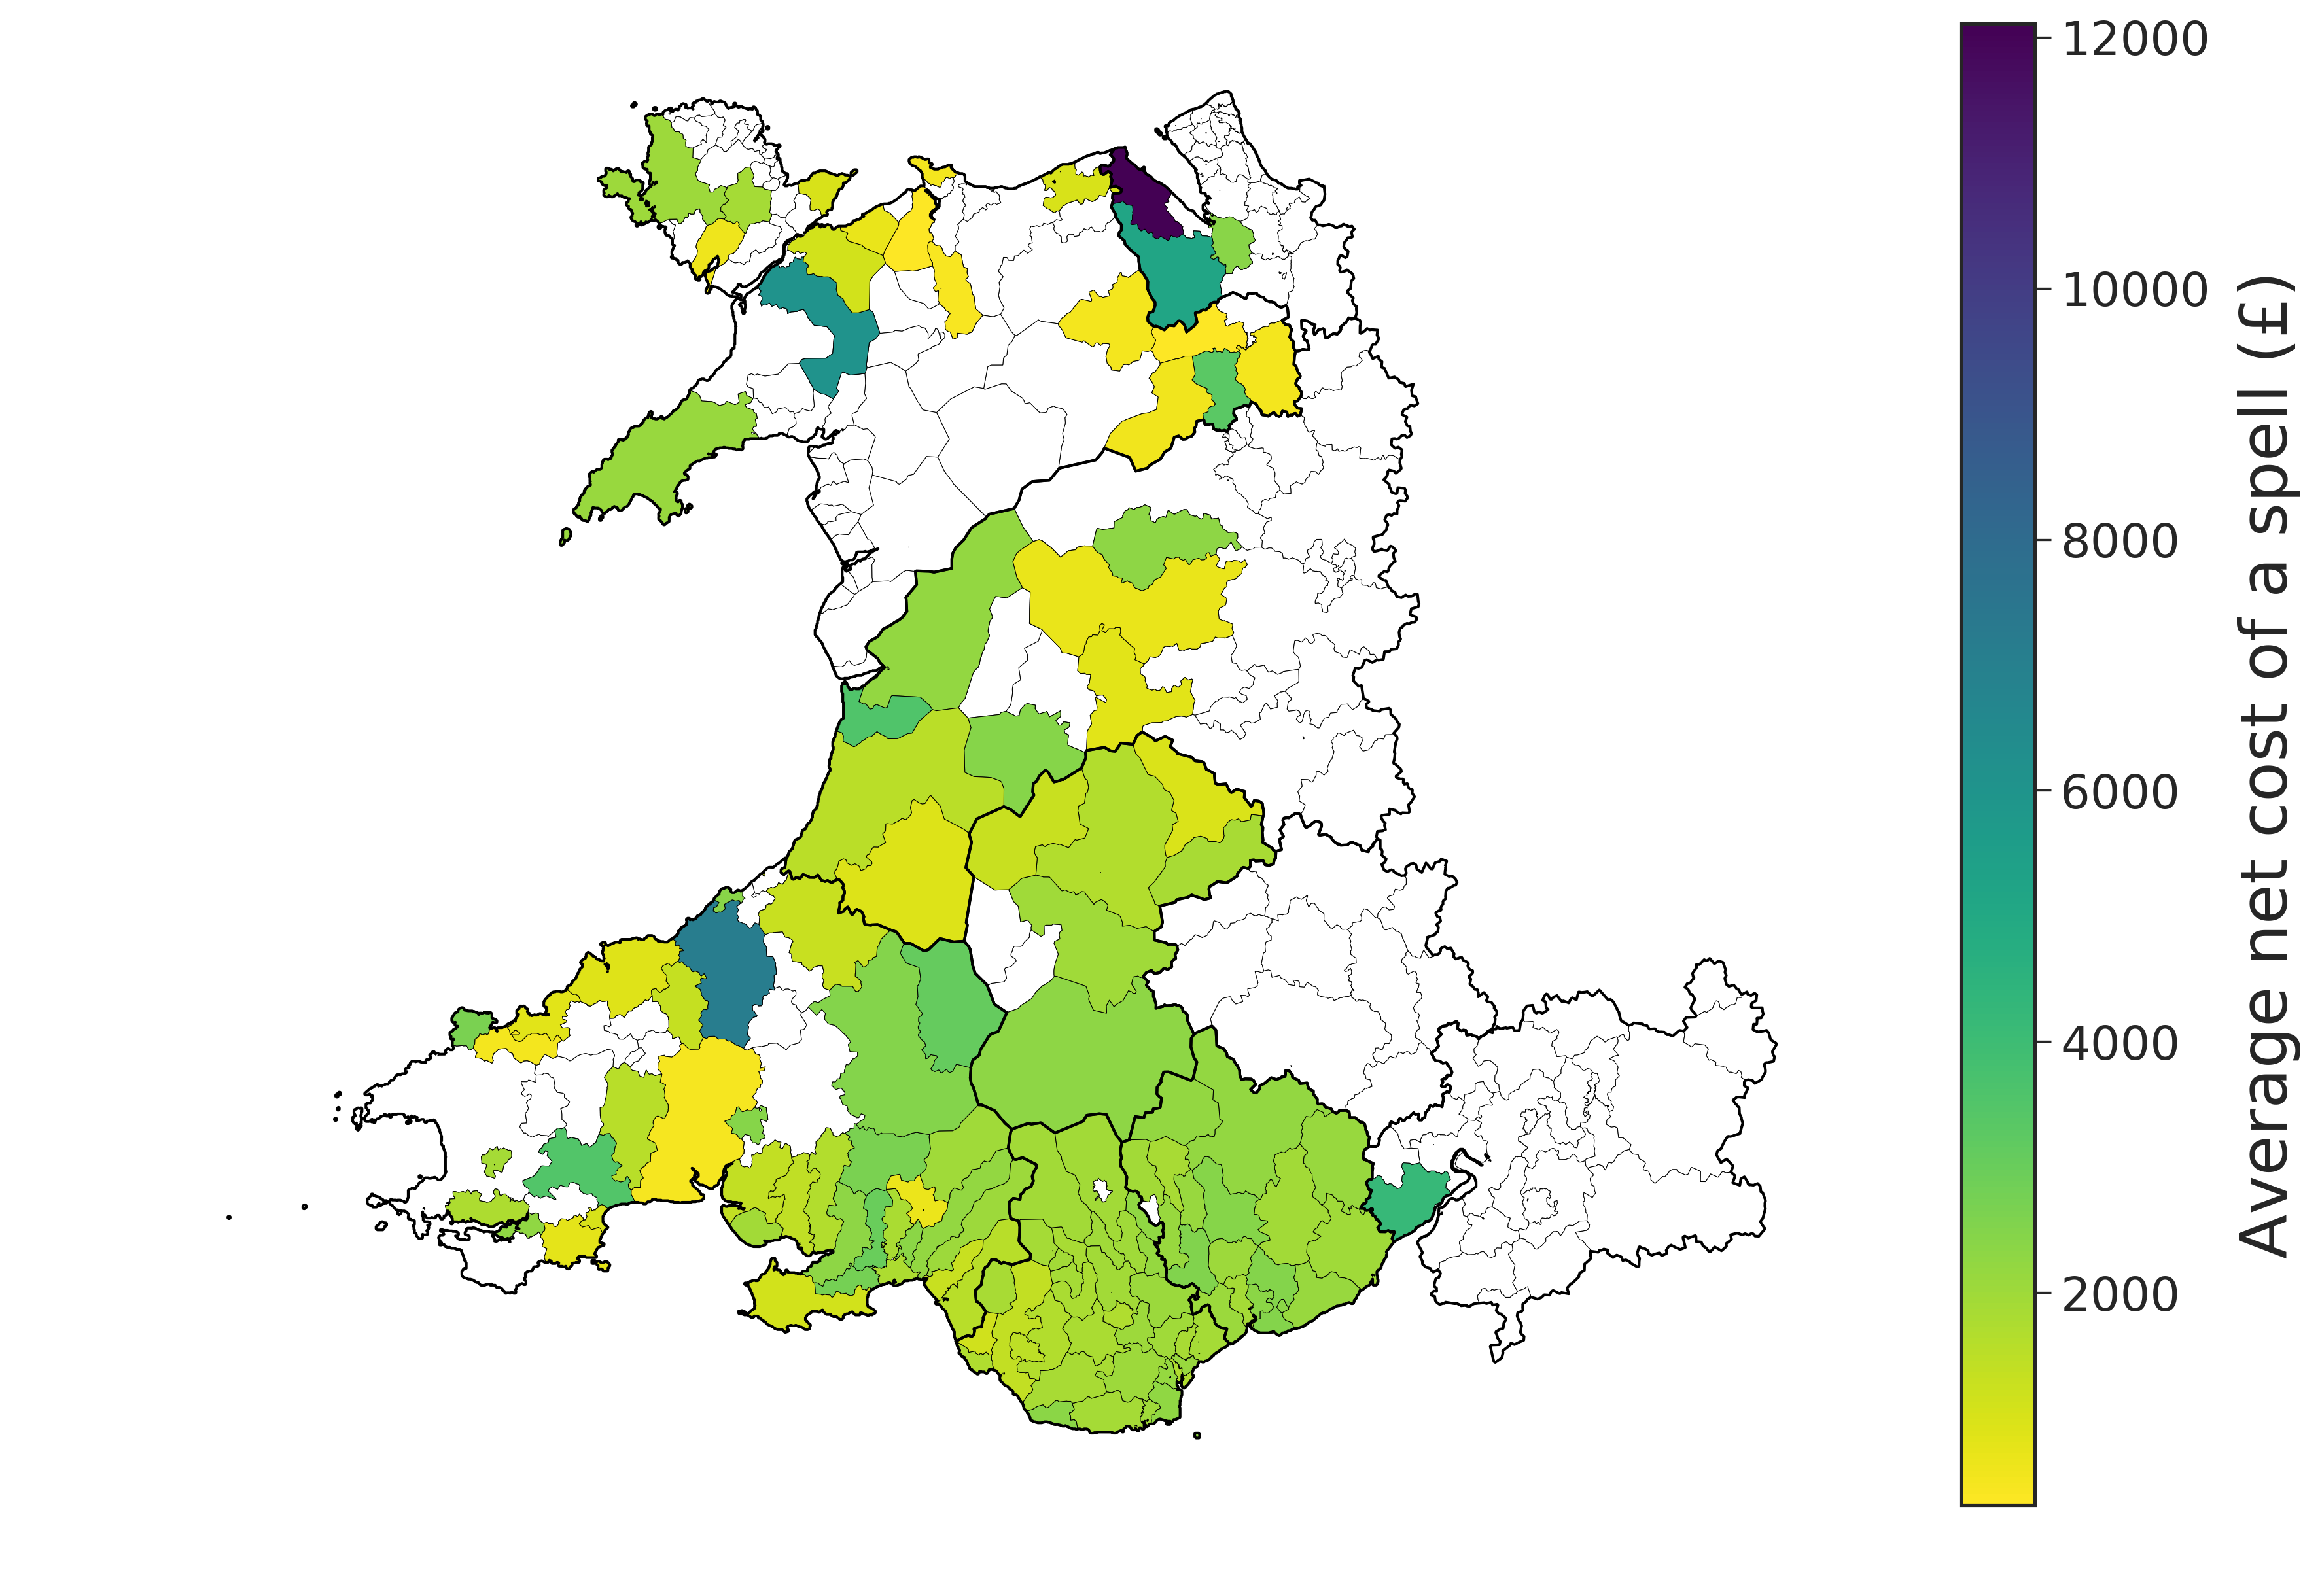

In [71]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

vmin = our_districts['avg_netcost'].min()
vmax = our_districts['avg_netcost'].max()

welsh_districts.plot(
    ax=ax, color='white', edgecolor='k', linewidth=0.25
)
our_districts.plot(
    'avg_netcost', cmap='viridis_r', ax=ax,
    vmin=vmin, vmax=vmax, edgecolor='k', linewidth=0.25
)
welsh_areas.plot(
    ax=ax, facecolor='None', edgecolor='k', linewidth=1
)

sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.set_ylabel('Average net cost of a spell (£)', fontsize=24)

for label in cbar.ax.get_xticklabels():
    label.set_fontsize(24)

ax.axis('off')

plt.savefig('/Users/henrywilde/thesis/tex/data-analysis/img/external/netcost_wales.pdf', transparent=True);

In [ ]:
our_districts['estimated_cost'] = our_districts['avg_netcost'] * our_districts['patient_count']
our_districts['proportion_cost'] = our_districts['estimated_cost'] / our_districts['estimated_cost'].sum()

# Coefficient of variation for net cost

In [ ]:
our_districts['centroid'] = our_districts['geometry'].centroid

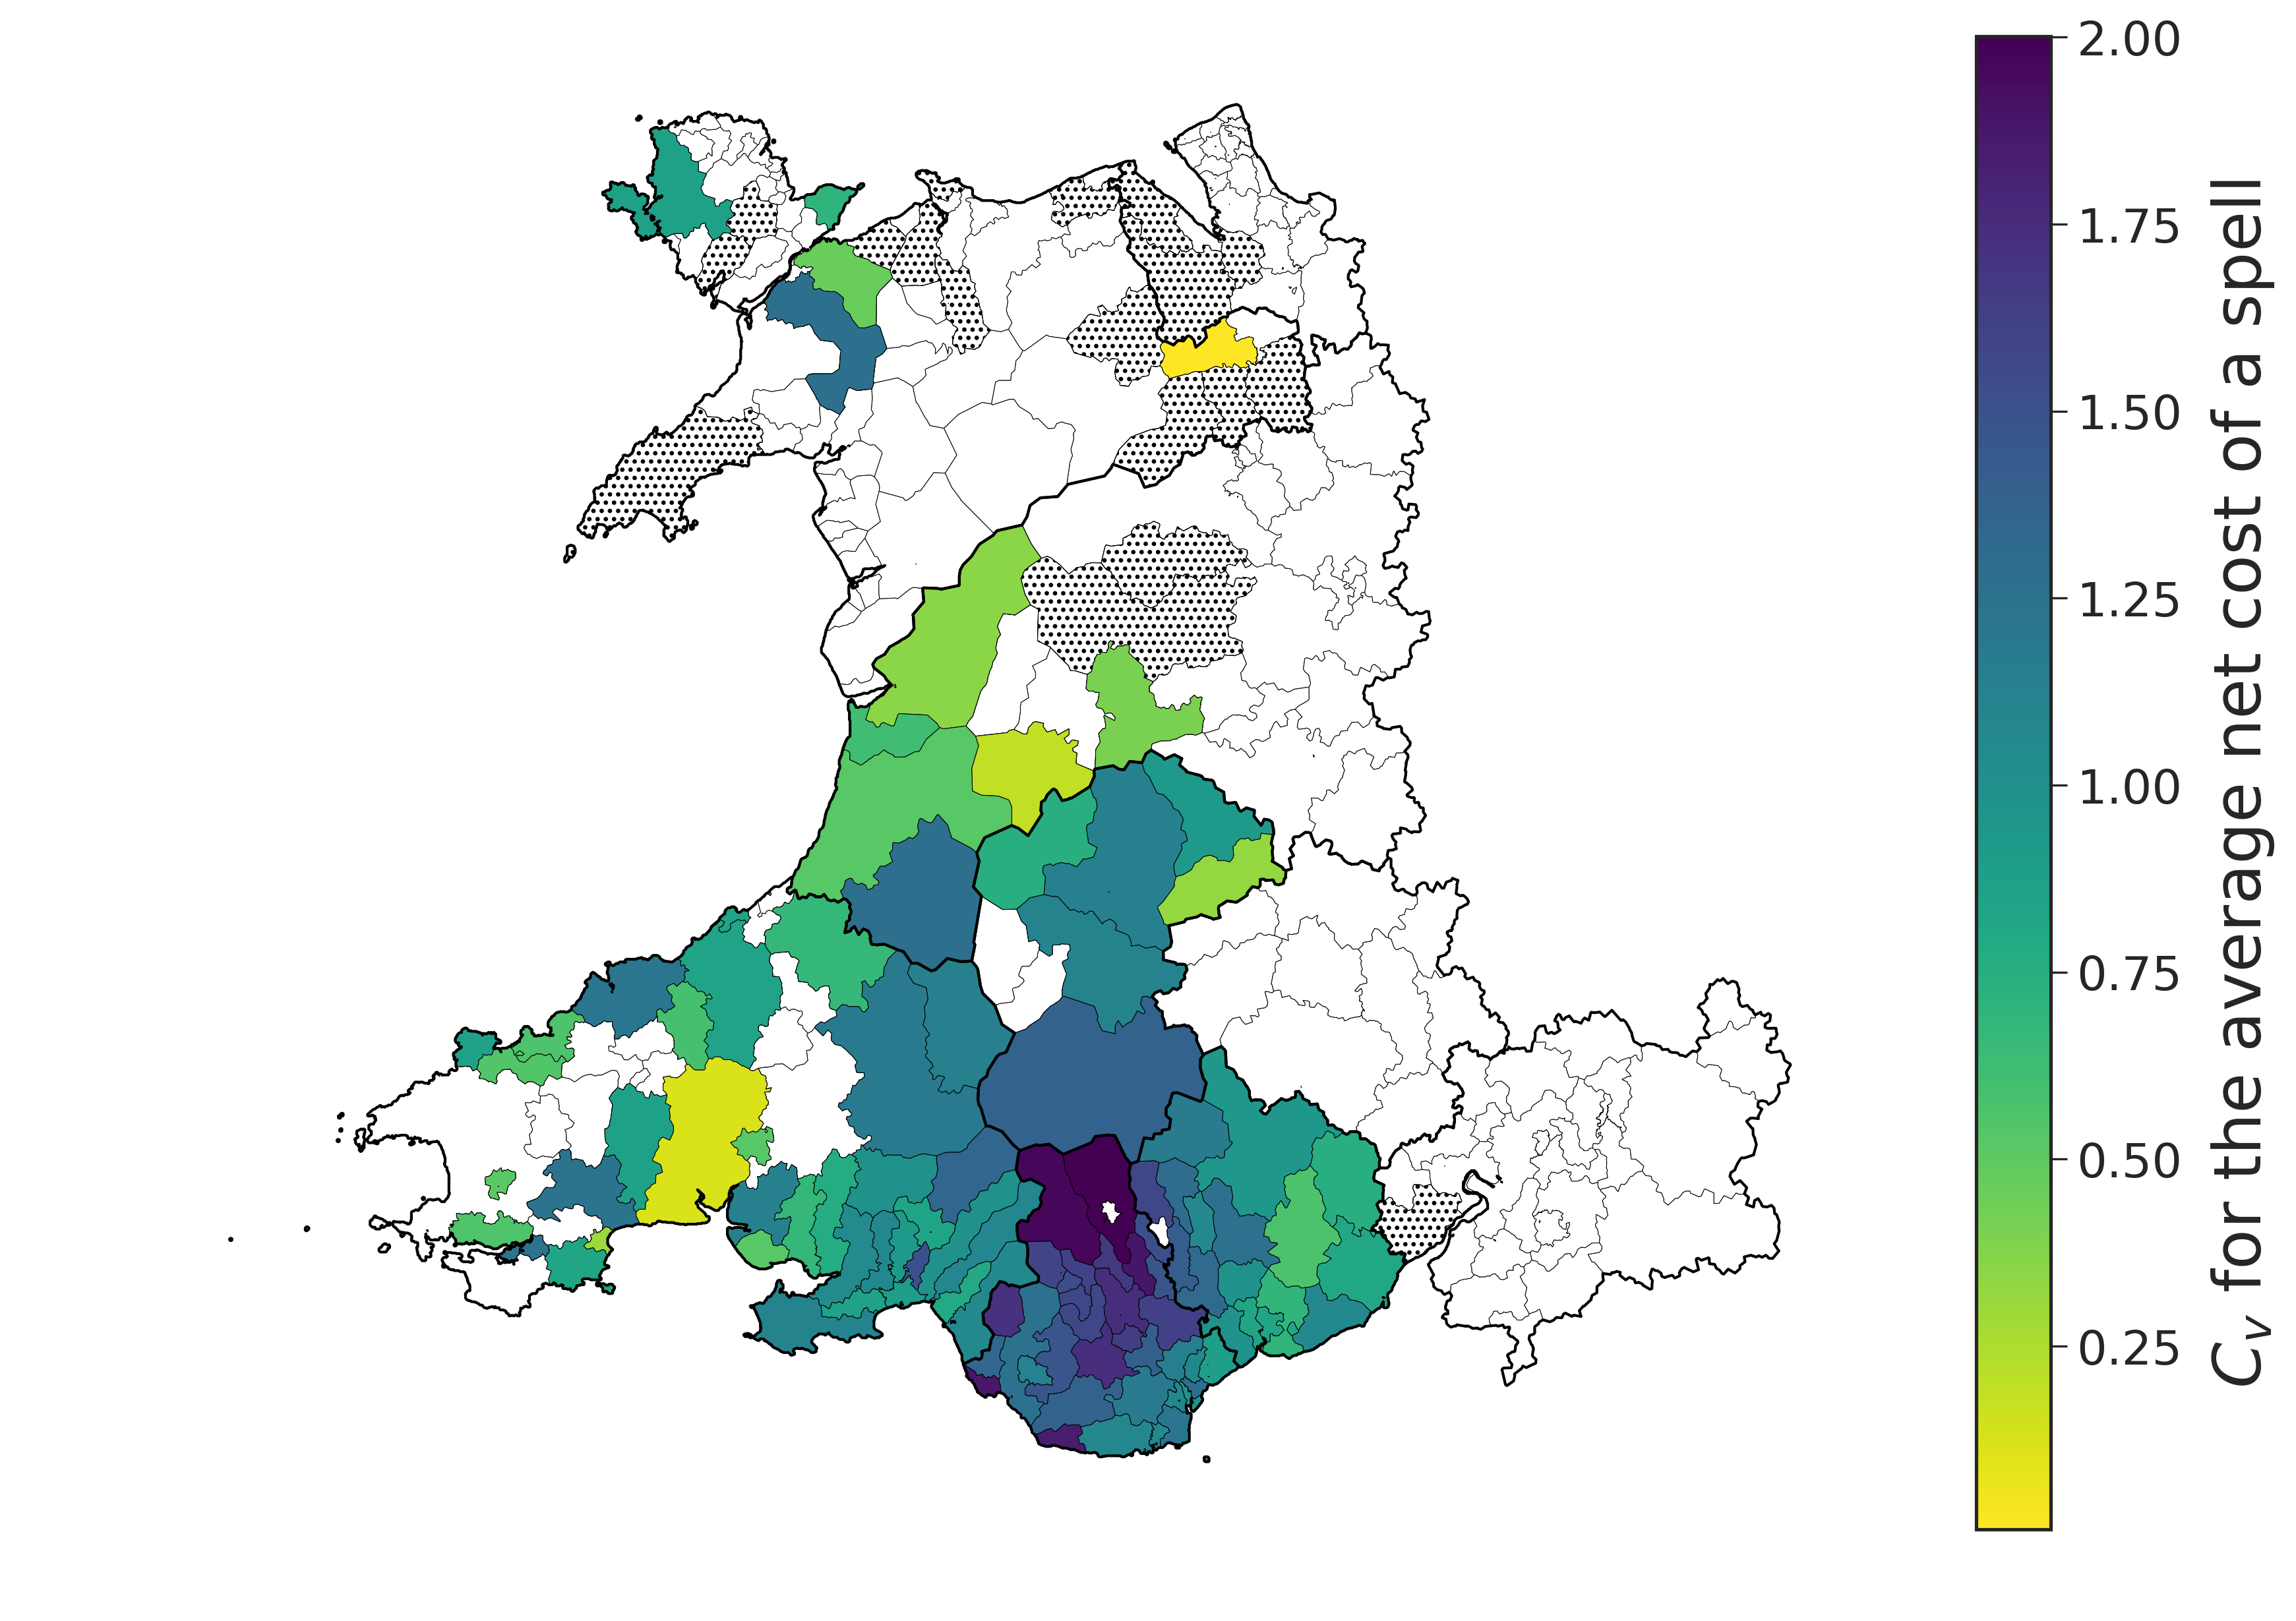

In [72]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

vmin = our_districts['var_netcost'].min()
vmax = our_districts['var_netcost'].max()

welsh_districts.plot(
    ax=ax, color='white', edgecolor='k', linewidth=0.25
)
our_districts.plot(
    ax=ax, hatch='....', facecolor='None', edgecolor='k', linewidth=0.25
)
our_districts.dropna(subset=['var_netcost'], axis=0)\
             .plot(
                 'var_netcost', cmap='viridis_r', ax=ax,
                 vmin=vmin, vmax=vmax, edgecolor='k', linewidth=0.25
             )
welsh_areas.plot(
    ax=ax, facecolor='None', edgecolor='k', linewidth=1
)

sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.set_ylabel(r'$C_v$ for the average net cost of a spell', fontsize=24)

for label in cbar.ax.get_xticklabels():
    label.set_fontsize(24)

ax.axis('off')

plt.savefig('/Users/henrywilde/thesis/tex/data-analysis/img/external/variation_wales.pdf', transparent=True);

# Average length of stay

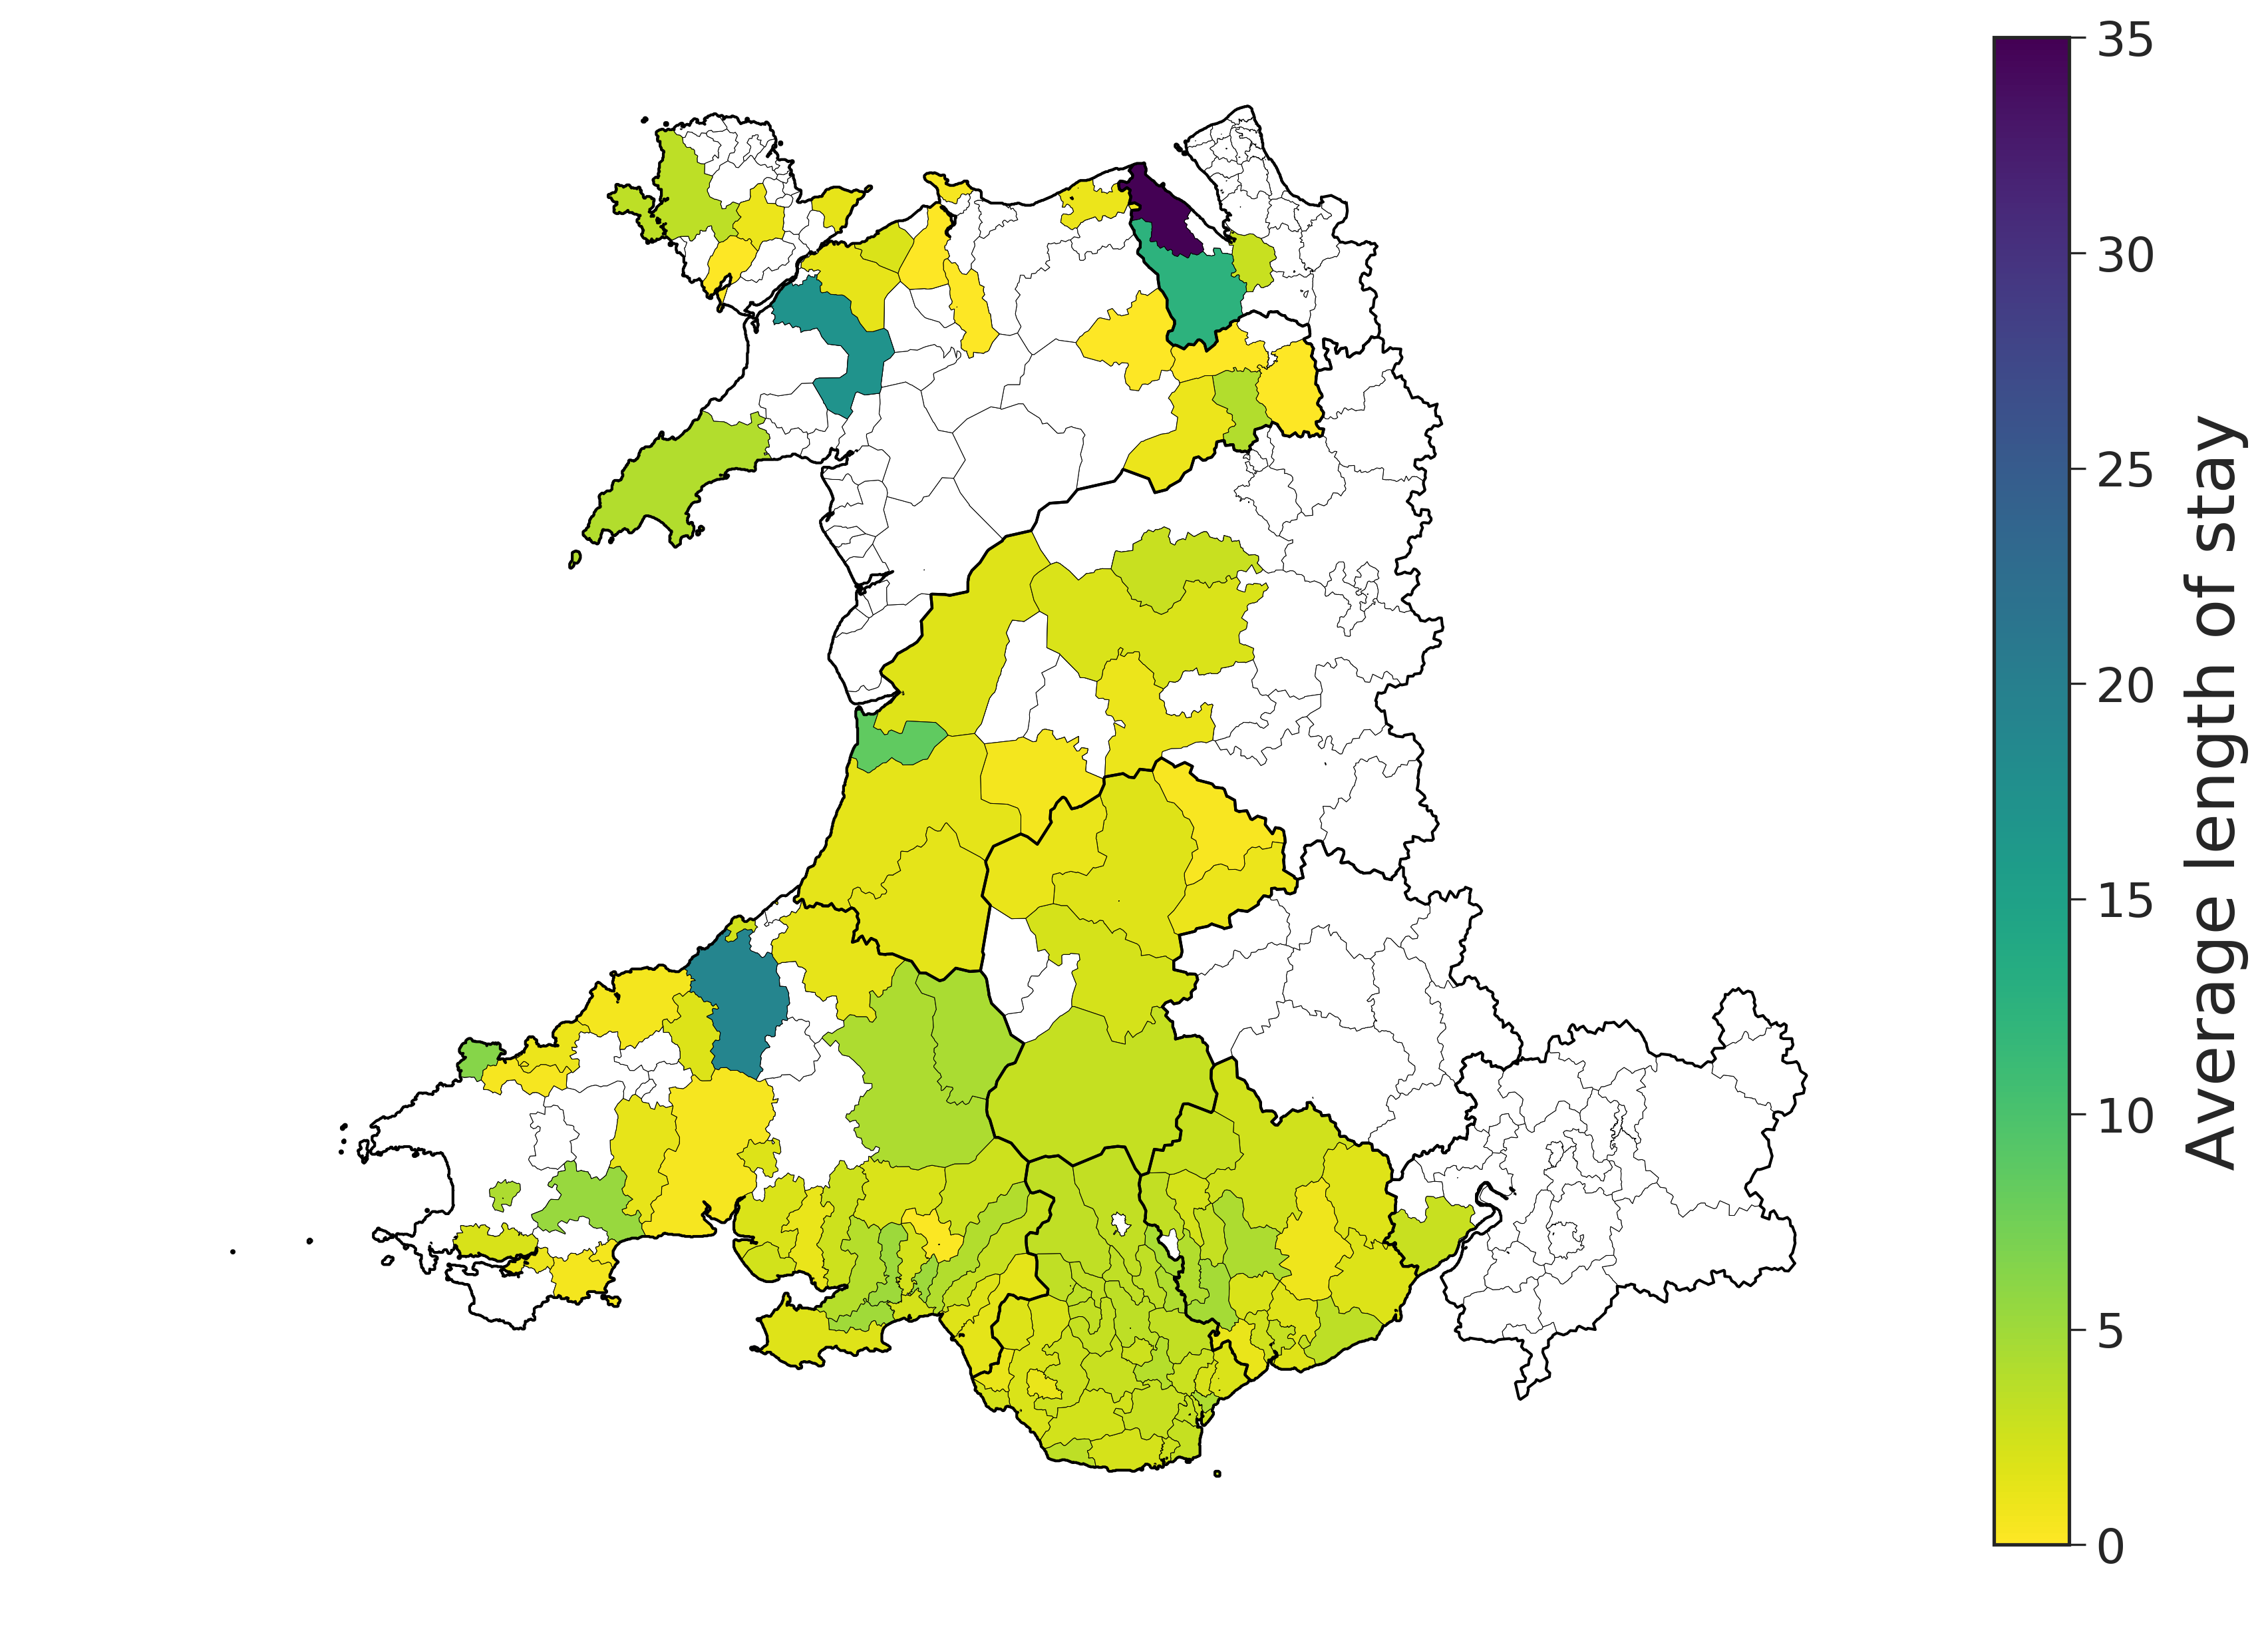

In [73]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

vmin = our_districts['avg_LOS'].min()
vmax = our_districts['avg_LOS'].max()

welsh_districts.plot(
    ax=ax, color='white', edgecolor='k', linewidth=0.25
)
our_districts.plot(
    'avg_LOS', cmap='viridis_r',
    vmin=vmin, vmax=vmax, ax=ax, edgecolor='k', linewidth=0.25
)
welsh_areas.plot(
    ax=ax, facecolor='None', edgecolor='k', linewidth=1
)

sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.set_ylabel("Average length of stay", fontsize=24)

for label in cbar.ax.get_xticklabels():
    label.set_fontsize(24)

ax.axis('off')

plt.savefig('/Users/henrywilde/thesis/tex/data-analysis/img/external/LOS_wales.pdf', transparent=True);

# Looking at Cwm Taf HB specifically

In [ ]:
cthb_districts = our_districts.loc[our_districts['postcode_area'].isin(['CF', 'NP'])]
cthb_areas = areas.loc[areas['name'].isin(['CF', 'NP'])]

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

vmin = cthb_districts['var_netcost'].min()
vmax = cthb_districts['var_netcost'].max()

cthb_districts.plot(
    'var_netcost', cmap='viridis_r', ax=ax,
    vmin=vmin, vmax=vmax, edgecolor='k', linewidth=0.25
)
cthb_areas.plot(
    ax=ax, facecolor='None', edgecolor='k', linewidth=2
)

for point in hospital_locs.iterrows():
    ax.scatter(
        point[1]['centroid'].x,
        point[1]['centroid'].y,
        s=50, color='r'
    )
    ax.text(
        point[1]['centroid'].x + 0.01,
        point[1]['centroid'].y + 0.01,
        point[1]['name'],
        color='r',
        fontsize=14,
        weight='bold'
    )

sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, label=r'$C_v$ for the average net cost of a spell')

ax.axis('off')

plt.savefig('/Users/henrywilde/thesis/tex/overview/img/external/variation_CT.pdf', transparent=True);

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

vmin = cthb_districts['avg_netcost'].min()
vmax = cthb_districts['avg_netcost'].max()

cthb_districts.plot('avg_netcost', cmap='viridis_r', ax=ax,
                    vmin=vmin, vmax=vmax, edgecolor='k', linewidth=0.25)
cthb_areas.plot(ax=ax, facecolor='None', edgecolor='k', linewidth=2)

for point in hospital_locs.iterrows():
    ax.scatter(
        point[1]['centroid'].x,
        point[1]['centroid'].y,
        s=50, color='r'
    )
    ax.text(
        point[1]['centroid'].x + 0.01,
        point[1]['centroid'].y + 0.01,
        point[1]['name'],
        color='r',
        fontsize=14,
        weight='bold'
    )

sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, label='Average net cost of a spell')

ax.axis('off')

plt.savefig('/Users/henrywilde/thesis/tex/overview/img/external/netcost_CT.pdf', transparent=True);

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

vmin = cthb_districts['log_patient'].min()
vmax = cthb_districts['log_patient'].max()

cthb_districts.plot(
    'log_patient', cmap='viridis_r', ax=ax,
    vmin=vmin, vmax=vmax, edgecolor='k', linewidth=0.25
)
cthb_areas.plot(ax=ax, facecolor='None', edgecolor='k', linewidth=2)

for point in hospital_locs.iterrows():
    ax.scatter(
        point[1]['centroid'].x,
        point[1]['centroid'].y,
        s=50, color='r'
    )
    ax.text(
        point[1]['centroid'].x + 0.01,
        point[1]['centroid'].y + 0.01,
        point[1]['name'],
        color='r',
        fontsize=14,
        weight='bold'
    )

sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, label='Logarithm of proportion of patients')

ax.axis('off')

plt.savefig('/Users/henrywilde/thesis/tex/overview/img/external/log_proportion_CT.pdf');

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

vmin = cthb_districts['avg_LOS'].min()
vmax = cthb_districts['avg_LOS'].max()

cthb_districts.plot(
    'avg_LOS', cmap='viridis_r', ax=ax,
    vmin=vmin, vmax=vmax, edgecolor='k', linewidth=0.25
)
cthb_areas.plot(ax=ax, facecolor='None', edgecolor='k', linewidth=2)

for point in hospital_locs.iterrows():
    ax.scatter(
        point[1]['centroid'].x,
        point[1]['centroid'].y,
        s=50, color='r'
    )
    ax.text(
        point[1]['centroid'].x + 0.01,
        point[1]['centroid'].y + 0.01,
        point[1]['name'],
        color='r',
        fontsize=14,
        weight='bold'
    )

sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, label='Average length of stay')

ax.axis('off')

plt.savefig('/Users/henrywilde/thesis/tex/overview/img/external/LOS_CT.pdf');

# Days of the week

In [ ]:
df['Day of week (admission)'] = df['ADMDATE'].dt.day_name()

## Net costs

In [ ]:
fig, (week, end) = plt.subplots(nrows=2, ncols=4, figsize=(60, 35), dpi=300)

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday']
weekend_days = ['Friday', 'Saturday', 'Sunday']

for day in weekdays + weekend_days:
    day_df = df[df['Day of week (admission)'] == day]

    mean_netcost = day_df.groupby(['practice_code', 'SPELL_ID'])['NetCost'].sum()\
                                                                           .reset_index()\
                                                                           .groupby('practice_code')['NetCost']\
                                                                           .mean()\
                                                                           .loc[known_practice_codes]

    mean_netcost = mean_netcost[~mean_netcost.index.duplicated(keep='first')]

    our_practices = our_practices.set_index('PracticeCode')
    our_practices['avg_netcost'] = mean_netcost
    our_practices = our_practices.reset_index()

    avg_netcosts = our_practices.groupby('District')['avg_netcost'].mean()

    our_districts = our_districts.set_index('name')
    our_districts['avg_netcost'] = avg_netcosts
    our_districts = our_districts.reset_index()

    cthb_districts = our_districts.loc[our_districts['postcode_area'].isin(['CF', 'NP'])]

    vmin = cthb_districts['avg_netcost'].min()
    vmax = cthb_districts['avg_netcost'].max()
    
    if day in weekdays:
        j = weekdays.index(day)
        ax = week[j]
    else:
        j = weekend_days.index(day)
        ax = end[j]

    cthb_districts.plot(ax=ax, facecolor='None',
                        hatch='....', edgecolor='k',
                        lw=0.25)
        
    cthb_districts.dropna().plot(
        'avg_netcost', cmap='viridis_r', ax=ax,
        vmin=vmin, vmax=vmax, edgecolor='k', linewidth=0.25
    )
    cthb_areas.plot(ax=ax, facecolor='None', edgecolor='k', linewidth=2)

    ax.set_title(day.title(), fontsize=40)
    ax.axis('off')

end[-1].axis('off')
    
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_ylabel('Average net cost (£)', fontsize=40)

for label in cbar.ax.get_yticklabels():
    label.set_fontsize(30)
    
plt.savefig('/Users/henrywilde/thesis/tex/overview/img/external/daily_netcost.pdf', transparent=True);

## Length of stay

In [ ]:
fig, (week, end) = plt.subplots(nrows=2, ncols=4, figsize=(60, 35), dpi=300)

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday']
weekend_days = ['Friday', 'Saturday', 'Sunday']

for day in weekdays + weekend_days:
    day_df = df[df['Day of week (admission)'] == day]

    lengths = day_df.drop_duplicates('SPELL_ID').groupby('practice_code')['TRUE_LOS']\
                                                .mean()\
                                                .loc[known_practice_codes]

    lengths = lengths[~lengths.index.duplicated(keep='first')]

    our_practices = our_practices.set_index('PracticeCode')
    our_practices['length'] = lengths
    our_practices = our_practices.reset_index()

    mean_length = our_practices.groupby('District')['length'].mean()

    our_districts = our_districts.set_index('name')
    our_districts['mean_length'] = mean_length
    our_districts = our_districts.reset_index()

    cthb_districts = our_districts.loc[our_districts['postcode_area'].isin(['CF', 'NP'])]

    vmin = cthb_districts['mean_length'].min()
    vmax = cthb_districts['mean_length'].max()
    
    if day in weekdays:
        j = weekdays.index(day)
        ax = week[j]
    else:
        j = weekend_days.index(day)
        ax = end[j]

    cthb_districts.plot(ax=ax, facecolor='None',
                        hatch='....', edgecolor='k',
                        lw=0.25)
        
    cthb_districts.dropna().plot(
        'mean_length', cmap='viridis_r', ax=ax,
        vmin=vmin, vmax=vmax, edgecolor='k', linewidth=0.25
    )
    cthb_areas.plot(ax=ax, facecolor='None', edgecolor='k', linewidth=2)

    ax.set_title(day.title(), fontsize=40)
    ax.axis('off')

end[-1].axis('off')
    
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_ylabel('Average length of stay (days)', fontsize=40)

for label in cbar.ax.get_yticklabels():
    label.set_fontsize(30)

plt.savefig('/Users/henrywilde/thesis/tex/overview/img/external/daily_LOS.pdf', transparent=True);